-Compute T(E,z_in, z_dep) by doing a delta function injection

-Why don't we ever keep track of how much DM is being depleted through annihilation/decay?

TODO:
- make contour plots
    - Pick a mass and make the plot corresponding to a vertical line going through the contour plot
    - Make a course contour plot
    - Once everything is debugged, make a very fine contour plot
- Clean up this Example12
    - migrate the main evolve function into a main.py that is conspicuous for the casual user
    - Change the inputs so that xe_init and T_init are computed for the user.
    - Make sure that the transfer functions are never seen (take them out of the input)
    - plots comparing back-reaction and no back-reaction
    - allow electron annihilation

# Full Transfer Functions

In [10]:
%load_ext autoreload
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs

# np.set_printoptions(threshold=np.nan)

In the standard temperature/ionization history calculation,
one solves the TLA assuming no DM energy injection. 

$$ \dot{T}_m = -2 H T_m + \Gamma_C \left(T_{CMB} - T_m \right), $$
$$ \dot{x}_e = - \mathcal{C} \left[ n_H x_e^2 \alpha_B - 4 (1 - x_e) \beta_B e^{-E_{21}/T_{CMB}} \right]. $$

The solution to these coupled ODEs provides $x_e$ and $T_m$ as functions of z, which are loaded below.

In [12]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

To include the effect of DM energy injection, one adds to the TLA the following terms

$$ \dot{T}^\chi_m = \frac{2 f_\text{heat}(z)}{3 (1 + f_\text{He} + x_e(z)) n_H(z)} \left(\frac{dE}{dV \, dt} \right)^\text{inj}, $$
$$ \dot{x}^\chi_e = \left[\frac{f_\text{ion}(z)}{\mathcal{R} n_H(z)} + \frac{(1-\mathcal{C}) \; f_\text{exc}(z)}{0.75 \mathcal{R} n_H(z)} \right] \left(\frac{dE}{dV \, dt} \right)^\text{inj}. $$

Apparently one must know $f_{\{\text{heat, ion, exc}\}}(z)$ for all z to solve the TLA, which requires a knowledge of $x_e(z)$ and the histories of the DM decay/annihilation products.

## Photon Transfer Functions

In [13]:
user = 'gridgway'

highengphot_tflist_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_complete_coarse.raw", "rb"))
lowengphot_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_complete_coarse.raw", "rb"))
lowengelec_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_complete_coarse.raw", "rb"))
CMB_engloss_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_complete_coarse.raw", "rb"))

In [14]:
# pickle.dump(
#     T_IGM_17_elec_pwave, 
#     open('/Users/gridgway/Desktop/T_IGM_17_elec_pwave_recomb_NFW_no_subs_new.dat','wb')
# )

In [15]:
highengphot_tflist_arr[0].eng

array([1.03884797e-04, 1.12113005e-04, 1.20992928e-04, 1.30576187e-04,
       1.40918488e-04, 1.52079953e-04, 1.64125463e-04, 1.77125039e-04,
       1.91154248e-04, 2.06294642e-04, 2.22634233e-04, 2.40268003e-04,
       2.59298457e-04, 2.79836221e-04, 3.02000681e-04, 3.25920680e-04,
       3.51735264e-04, 3.79594496e-04, 4.09660321e-04, 4.42107514e-04,
       4.77124690e-04, 5.14915405e-04, 5.55699338e-04, 5.99713568e-04,
       6.47213949e-04, 6.98476604e-04, 7.53799523e-04, 8.13504300e-04,
       8.77938001e-04, 9.47475181e-04, 1.02252006e-03, 1.10350888e-03,
       1.19091243e-03, 1.28523878e-03, 1.38703626e-03, 1.49689663e-03,
       1.61545850e-03, 1.74341107e-03, 1.88149814e-03, 2.03052242e-03,
       2.19135018e-03, 2.36491632e-03, 2.55222979e-03, 2.75437944e-03,
       2.97254038e-03, 3.20798077e-03, 3.46206926e-03, 3.73628285e-03,
       4.03221556e-03, 4.35158765e-03, 4.69625565e-03, 5.06822311e-03,
       5.46965230e-03, 5.90287673e-03, 6.37041476e-03, 6.87498419e-03,
      

In [16]:
photeng = highengphot_tflist_arr[0].eng
eleceng = lowengelec_tflist_arr[0].eng

#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3000]
eleceng_low  = eleceng[eleceng <= 3000]


for highengphot_tflist in highengphot_tflist_arr:
    
#     highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

    for tf in highengphot_tflist:
        # tf.rebin(photeng_high)
#         tf.rebin(photeng)
        
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (0, 0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    highengphot_tflist._eng = photeng
    highengphot_tflist._in_eng = photeng
    highengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in highengphot_tflist._tflist])
    )
    
# lowengphot_tflist.in_eng set to photeng_high
for lowengphot_tflist in lowengphot_tflist_arr:
    
#     lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengphot_tflist:
#         tf.rebin(photeng)
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        # Photons in the low energy bins should be immediately deposited.
        tf._grid_vals[0:photeng_low.size, 0:photeng_low.size] = np.identity(photeng_low.size)
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    lowengphot_tflist._eng = photeng
    lowengphot_tflist._in_eng = photeng
    lowengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengphot_tflist._tflist])
    )
    
# lowengelec_tflist.in_eng set to photeng_high 
for lowengelec_tflist in lowengelec_tflist_arr:
    
#     lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengelec_tflist:
#         tf.rebin(eleceng)
        # Pad with zeros so that it becomes photeng x eleceng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = eleceng
        tf._rs = tf.rs[0]*np.ones_like(photeng)

    lowengelec_tflist._eng = eleceng
    lowengelec_tflist._in_eng = photeng
    lowengelec_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengelec_tflist._tflist])
    )
    
    for engloss in CMB_engloss_arr:
        engloss = np.pad(engloss, ((0,0),(photeng_low.size, 0)), 'constant')


In [17]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])


In [18]:
mDM = 1e11

highengphot_tf_interp = tflist.TransferFuncInterp(xes, highengphot_tflist_arr)
lowengphot_tf_interp = tflist.TransferFuncInterp(xes, lowengphot_tflist_arr)
lowengelec_tf_interp = tflist.TransferFuncInterp(xes, lowengelec_tflist_arr)


phot_spec_init = spectools.rebin_N_arr(np.array([1]), 
                                      np.array([mDM]), 
                                      photeng)
phot_spec_init.switch_spec_type()


In [19]:
%autoreload
phot_spec_init.rs = 3000
end_rs   = 2950
#mDM = 1e8
sigmav = 1e-26
tau = 1e24

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)


def evolve(
    in_spec_elec, in_spec_phot, 
    rate_func_N, rate_func_eng, xe_init, T_m_init,
    highengphot_tf_interp, lowengphot_tf_interp, 
    lowengelec_tf_interp, 
    end_rs, coarsen_factor=1, std_soln=False
):
    """
    Main function that computes the temperature and ionization history. 
    
    Parameters
    ----------
    in_spec_elec : Spectrum
        Spectrum per annihilation/decay into electrons. 
    in_spec_phot : Spectrum
        Spectrum per annihilation/decay into photons.
    rate_func_N : function
        Function describing the rate of annihilation/decay, dN/(dV dt)
    rate_func_eng : function
        Function describing the rate of annihilation/decay, dE/(dV dt)
    xe_init : float
        xe at the initial redshift. 
    T_m_init : float
        Matter temperature at the initial redshift. 
    highengphot_tf_interp : TransferFuncInterp
        Interpolation table for high energy photons. 
    lowengphot_tf_interp : TransferFuncInterp
        Interpolation table for low energy photons. 
    lowengelec_tf_interp : TransferFuncInterp
        Interpolation table for low energy electrons. 
    end_rs : float
        Final redshift to evolve to. 
    coarsen_factor : int
        Coarsening to apply to the transfer function matrix. 
    std_soln : bool
        If true, uses the standard TLA solution for f(z). 
    """
    
    # Initialize the next spectrum as None.
    next_highengphot_spec = None
    next_lowengphot_spec  = None
    next_lowengelec_spec  = None
    
    if (
        highengphot_tf_interp.dlnz    != lowengphot_tf_interp.dlnz
        or highengphot_tf_interp.dlnz != lowengelec_tf_interp.dlnz
        or lowengphot_tf_interp.dlnz  != lowengelec_tf_interp.dlnz
    ):
        raise TypeError('TransferFuncInterp objects must all have the same dlnz.')
    
    if in_spec_elec.rs != in_spec_phot.rs:
        raise TypeError('Input spectra must have the same rs.')
    
    # redshift/timestep related quantities. 
    dlnz = highengphot_tf_interp.dlnz
    prev_rs = None
    rs = in_spec_phot.rs
    dt = dlnz/phys.hubble(rs)
    
    # The initial input dN/dE per annihilation to per baryon per dlnz, 
    # based on the specified rate. 
    # dN/(dN_B d lnz dE) = dN/dE * (dN_ann/(dV dt)) * dV/dN_B * dt/dlogz
    
    # ICS for in_spec_elec goes here.
    
    # (Should this be multiplied by dlnz?)
    init_inj_spec = (
        in_spec_phot * rate_func_N(rs) * dt / (phys.nB * rs**3)
    )
    
    
    # Initialize the Spectra object that will contain all the 
    # output spectra during the evolution.
    out_highengphot_specs = Spectra([init_inj_spec], spec_type=init_inj_spec.spec_type)
    out_lowengphot_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    out_lowengelec_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    
    # Initialize the xe and T array that will store the solutions.
    xe_arr  = np.array([xe_init])
    T_m_arr = np.array([T_m_init])
    
    # Load the standard TLA solution if necessary. 
#     if std_soln:
    if True:
        soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
        xe_std  = interp1d(soln[0,:], soln[2,:])
        T_m_std = interp1d(soln[0,:], soln[1,:])

    # Define these methods for speed.
    append_highengphot_spec = out_highengphot_specs.append
    append_lowengphot_spec  = out_lowengphot_specs.append
    append_lowengelec_spec  = out_lowengelec_specs.append
    
    # Loop while we are still at a redshift above end_rs.
    while rs > end_rs:
        
        # If prev_rs exists, calculate xe and T_m. 
        if prev_rs is not None:
#             print('here at least?')
            
            # f_continuum, f_lyman, f_ionH, f_ionHe, f_heat
            # f_raw takes in dE/(dV dt)
            if std_soln:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt
                )
                print("\n SHOULD BE ONE: ", (next_lowengelec_spec.toteng() + next_lowengphot_spec.toteng())/(
                np.sum(f_raw) * rate_func_eng(rs) * dt / phys.nB / rs**3), '\n')
                
                print("\n SHOULD BE ONE: ", (rate_func_eng(rs) * dt / phys.nB / rs**3)/
                      (next_lowengelec_spec.toteng() + next_lowengphot_spec.toteng()), '\n')
                
            else:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt
                )
                
            std_f = compute_fs(
                next_lowengelec_spec, next_lowengphot_spec,
                np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt
            )
            
            backreaction_f = compute_fs(
                next_lowengelec_spec, next_lowengphot_spec,
                np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt
            )
            
            init_cond = np.array([T_m_arr[-1], xe_arr[-1], 0, 0])

            new_vals = tla.get_history(
                init_cond, f_raw[2], f_raw[1], f_raw[4], 
                rate_func_eng, np.array([prev_rs, rs]),
                reion_switch = False
            )

            T_m_arr = np.append(T_m_arr, new_vals[-1,0])
            xe_arr  = np.append(xe_arr,  new_vals[-1,1])
            
        print('T_m at '+str(rs)+': '+ str(T_m_arr[-1]))
        print('x_e at '+str(rs)+': '+ str(xe_arr[-1]))
        print('Standard x_e at '+str(rs)+': '+str(xe_std(rs)))
        if prev_rs is not None:
            print('Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat: ', backreaction_f)
            print('Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat: ', std_f)
            
        if std_soln:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_std(rs))
        else:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_arr[-1])
        
#         if coarsen_factor > 1:
#             prop_tf = np.zeros_like(highengphot_tf._grid_vals)
#             for i in np.arange(coarsen_factor):
#                 prop_tf += matrix_power(highengphot_tf._grid_vals, i)
#             lowengphot_tf._grid_vals = np.matmul(prop_tf, lowengphot_tf._grid_vals)
#             lowengelec_tf._grid_vals = np.matmul(prof_tf, lowengelec_tf._grid_vals)
#             highengphot_tf._grid_vals = matrix_power(
#                 highengphot_tf._grid_vals, coarsen_factor
#             )
            
        next_highengphot_spec = highengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengphot_spec  = lowengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengelec_spec  = lowengelec_tf.sum_specs(out_highengphot_specs[-1])
        
        print('\n SHOULD ALSO BE ONE: ', 
              out_highengphot_specs[-1].toteng(bound_type = 'eng', bound_arr = np.array([100,1e13]))/(
        next_highengphot_spec.toteng(bound_type = 'eng', bound_arr = np.array([100,1e13])) + 
            next_lowengphot_spec.toteng(bound_type = 'eng', bound_arr = np.array([100,1e13])) + 
            next_lowengelec_spec.toteng(bound_type = 'eng', bound_arr = np.array([100,1e13]))), '\n')
        
        # Re-define existing variables.
        prev_rs = rs
        rs = np.exp(np.log(rs) - 0.002)
        
        dt = dlnz/phys.hubble(rs)
        next_highengphot_spec.rs = rs
        next_lowengphot_spec.rs  = rs
        next_lowengelec_spec.rs  = rs
        
        # Add the next injection spectrum to next_highengphot_spec
        next_inj_spec = (
            in_spec_phot * rate_func_N(rs)* dt / (phys.nB * rs**3)
        )

        # This keeps the redshift. 
        next_highengphot_spec.N += next_inj_spec.N
        
        append_highengphot_spec(next_highengphot_spec)
        append_lowengphot_spec(next_lowengphot_spec)
        append_lowengelec_spec(next_lowengelec_spec)
        
        print('************************ END OF LOOP **************************')
        
        
    return (
        xe_arr, T_m_arr, 
        out_highengphot_specs, out_lowengphot_specs, out_lowengelec_specs
    )

In [20]:
#%%prun
# a = evolve(
#         phot_spec_init*0, phot_spec_init, 
#         rate_func_decay_N, rate_func_decay_eng, .9999, phys.TCMB(phot_spec_init.rs),
#         highengphot_tf_interp, lowengphot_tf_interp, 
#         lowengelec_tf_interp, 
#         end_rs, coarsen_factor=1, std_soln=False
#     )

b = evolve(
        phot_spec_init*0, phot_spec_init, 
        rate_func_decay_N, rate_func_decay_eng, xe_std(phot_spec_init.rs), phys.TCMB(phot_spec_init.rs),
        #rate_func_decay_N, rate_func_decay_eng, 2e-4, phys.TCMB(phot_spec_init.rs),
        highengphot_tf_interp, lowengphot_tf_interp, 
        lowengelec_tf_interp, 
        end_rs, coarsen_factor=1, std_soln=True
    )

T_m at 3000: 0.70459598745
x_e at 3000: 0.999999999999
Standard x_e at 3000: 0.999999999999

 SHOULD ALSO BE ONE:  [2.02867187] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000061718777157e-15 1.0000064331823462e-15 1.0000070536415385e-15 1.0000059600034828e-15
Goods:  0.00040102036169299953
Split by photon and electron deposition!
f_phot:  [4.45631818e-04 4.45756210e-06 2.59628596e-05 0.00000000e+00
 0.00000000e+00]
f_elec:  [4.01022853e-19 4.01022945e-19 4.01022300e-19 4.01023434e-19
 4.01020362e-04]

 SHOULD BE ONE:  1.0000406100769035 


 SHOULD BE ONE:  1140.1101689129528 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000061718777157e-15 1.0000064331823462e-15 1.0000070536415385e-15 1.0000059600034828e-15
Goods:  0.00040102036169299953
Split by photon and electron deposition!
f_phot:  [4.45631818e-04 4.45756210e-06 2.59628596e-05 0.00000000e+00
 0.00000000e

../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


T_m at 2994.005996001995: 0.7031880248265628
x_e at 2994.005996001995: 0.9999999971391236
Standard x_e at 2994.005996001995: 0.9999999971389522
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.45631818e-04 4.45756210e-06 2.59628596e-05 4.01020363e-19
 4.01020362e-04]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.45631818e-04 4.45756210e-06 2.59628596e-05 4.01023434e-19
 4.01020362e-04]

 SHOULD ALSO BE ONE:  [2.01166238] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000063964180565e-15 1.000006667229298e-15 1.0000073102615945e-15 1.000006176835558e-15
Goods:  0.0017798629108985574
Split by photon and electron deposition!
f_phot:  [0.00550696 0.00015042 0.00037937 0.         0.        ]
f_elec:  [1.77987200e-18 1.77987234e-18 1.77987070e-18 1.77987541e-18
 1.77986291e-03]

 SHOULD BE ONE:  1.0001328109286507 


 SHOULD BE ONE:  127.91572202752239 

Normalized electron heat,

T_m at 2952.38196016585: 0.6934119787102694
x_e at 2952.38196016585: 0.9999999963303707
Standard x_e at 2952.38196016585: 0.9999999963197965
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.01370457e-02 4.44721484e-04 1.04202913e-03 4.41379876e-18
 4.41376244e-03]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.01370457e-02 4.44721484e-04 1.04202913e-03 4.41380021e-18
 4.41376244e-03]

 SHOULD ALSO BE ONE:  [1.98914278] 

************************ END OF LOOP **************************


In [ ]:
%autoreload
import main

mDM = 1e11
phot_spec_init = spectools.rebin_N_arr(np.array([1]), 
                                      np.array([mDM]), 
                                      photeng)
phot_spec_init.switch_spec_type()

phot_spec_init.rs = 3000
end_rs   = 2000
#mDM = 1e8
sigmav = 1e-26
tau = 1e24

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)

a = main.evolve(
        phot_spec_init*0, phot_spec_init, 
        rate_func_decay_N, rate_func_decay_eng, end_rs, 
        xe_std(phot_spec_init.rs), phys.TCMB(phot_spec_init.rs), 
        coarsen_factor=1, std_soln=True
    )

start to evolve
Loading Transfer Functions for the first time.

Load them shits!



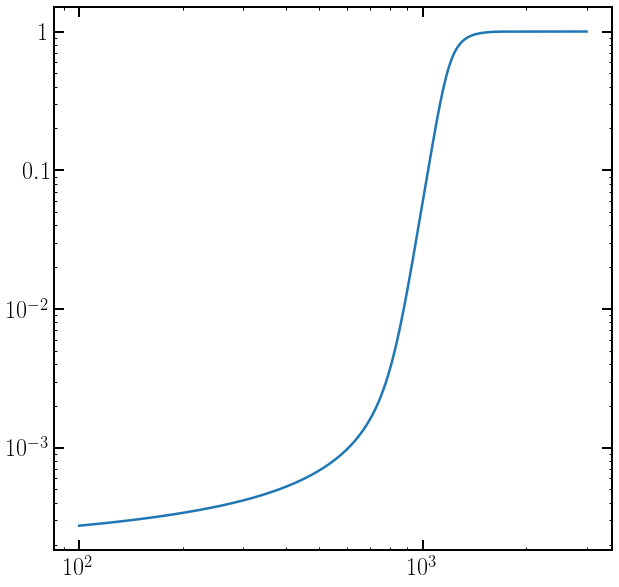

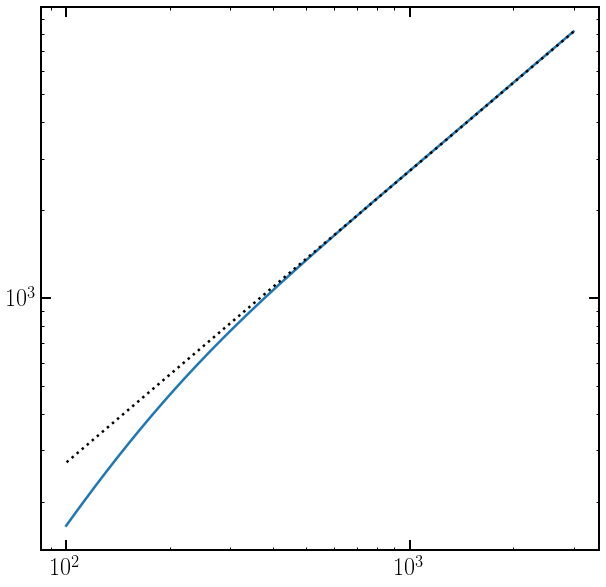

In [86]:
plt.figure()
# plt.plot(a[3].rs, a[0])
plt.plot(b[3].rs, b[0])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


plt.figure()
# plt.plot(a[3].rs, a[1]/phys.kB)
plt.plot(b[3].rs, b[1]/phys.kB)
plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


In [15]:
a[0]
a[3].rs[1:]

NameError: name 'a' is not defined

In [ ]:
a = 2
str(a)

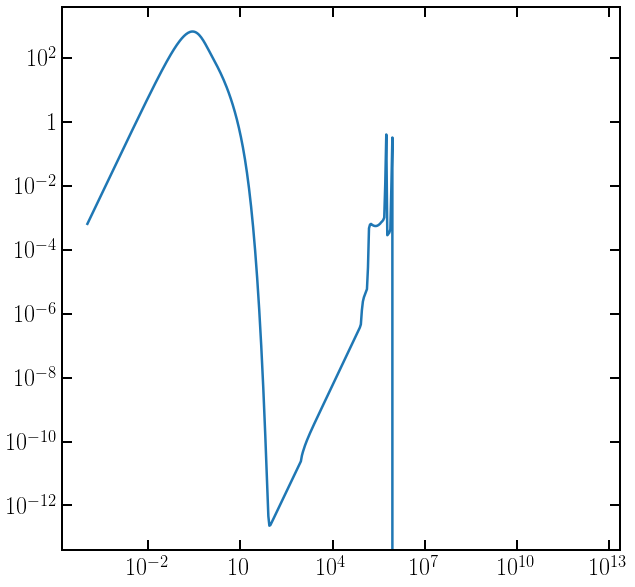

In [83]:
plt.figure()
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')

a = highengphot_tf_interp.get_tf(30, 2e-4)
a.plot(ax, ind = 300)